In [1]:
import gym
import math
import time
import random
import logging
import ECM_dVRL_v01
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from mpl_toolkits import mplot3d

env = gym.make('ECM-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.basicConfig(format = '%(message)s', level = logging.CRITICAL)

In [2]:
env.success_radius

0.1

In [3]:
"""action_j1 = np.round(np.arange(-0.0025, 0.00251, 0.0025), 4)
action_j2 = np.round(np.arange(-0.0025, 0.00251, 0.0025), 4)
action_j3 = np.round(np.arange(-0.0025, 0.00251, 0.0025), 4)
action_j4 = np.round(np.arange(-0.0025, 0.00251, 0.0025), 4)"""

action_j1 = np.round(np.arange(-0.0005, 0.00051, 0.0005), 4)
action_j2 = np.round(np.arange(-0.0005, 0.00051, 0.0005), 4)
action_j3 = np.round(np.arange(-0.0005, 0.00051, 0.0005), 4)
action_j4 = np.round(np.arange(-0.0005, 0.00051, 0.0005), 4)

action_space = []
for a1 in action_j1:
    for a2 in action_j2:
        for a3 in action_j3:
            for a4 in action_j4:
                action_space.append([a1, a2, a3, a4])
action_space = np.array(action_space)

In [4]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
class DQN(nn.Module):

    def __init__(self, inputs, outputs):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(inputs, 16)
        self.bn1 = nn.BatchNorm1d(16)
        self.layer2 = nn.Linear(16, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.layer3 = nn.Linear(32, outputs)
        #self.bn3 = nn.BatchNorm2d(outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.layer1(x)))
        x = F.relu(self.bn2(self.layer2(x)))
        x = F.relu(self.layer3(x))
        return x.view(1, x.size(1))

In [6]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 3

n_states = env.observation_space['observation'].shape[0]
# Get number of actions from gym action space
n_actions = action_space.shape[0]

policy_net = DQN(n_states, n_actions).to(device)
target_net = DQN(n_states, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    state = state.reshape((1, state.shape[0]))
    logging.debug(str(state.shape))
    policy_net.eval()
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1)
    else:
        return torch.tensor([random.randrange(n_actions)], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [7]:
all_losses = []
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    logging.debug('Generating Qs')
    batch_states = torch.split(state_batch, n_states)
    batch_actions = torch.split(action_batch, 1)
    
    sa_values = []
    policy_net.eval()
    for s, a in zip(batch_states, batch_actions):
        #sa_values.append((torch.tensor(policy_net(s.to(device)).view(1, n_actions).detach().cpu().numpy()[0][np.argmax(a.detach().cpu().numpy()[0])], dtype = torch.float32).view(1)))
        s = s.reshape((1, s.shape[0]))
        sa_values.append(policy_net(s.to(device)).max(1)[0].view(1))
    state_action_values = torch.cat(sa_values)
    
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    logging.debug('Generating Vs')
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    nsv = []
    nfn_states = torch.split(non_final_next_states, n_states)
    target_net.eval()
    for s in nfn_states:
        s = s.reshape((1, s.shape[0]))
        nsv.append(target_net(s.to(device)).max(1)[0].detach().view(1))
    
    next_state_values[non_final_mask] = torch.cat(nsv)
    
    """
    (Newest)
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch.to(device)).gather(1, action_batch)
    
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    # Compute the expected Q values
    #print (reward_batch.shape)
    """
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    
    loss = F.smooth_l1_loss(state_action_values.to(device), expected_state_action_values.unsqueeze(1))
    #print (type(state_action_values.to(device)),
          #type(expected_state_action_values.unsqueeze(1)))
    #all_losses.append(loss)
    # Optimize the model
    
    optimizer.zero_grad()
    loss.backward()
    #print (loss, end = '\r')
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [8]:
num_episodes = 5
episode_rewards = []
achieved_goals = []
step_rewards = []
start = time.time()
for i_episode in range(num_episodes):
    # Initialize the environment and state
    state = env.reset()
    print (f'Running episode {i_episode + 1}', end = '\r')
    logging.debug(str(i_episode + 1))
    for t in count():
        # Select and perform an action
        action = select_action(torch.tensor(state['observation'], dtype = torch.float32).to(device))
        action_index = action.cpu().numpy()[0]
        next_state, reward, done, info = env.step(action_space[action_index])
        reward = torch.tensor([reward], device=device)

        # Store the transition in memory
        memory.push(torch.tensor(state['observation'], dtype = torch.float32), 
                    action, torch.tensor(next_state['observation'], dtype = torch.float32), reward)

        # Move to the next state
        state = next_state
        step_rewards.append(reward.item())
        # Perform one step of the optimization (on the target network)
        optimize_model()
        
        if done:
            episode_durations.append(t + 1)
            episode_rewards.append(reward)
            plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    achieved_goals.append(next_state['achieved_goal'])
print (time.time() - start)
print('Complete')
#env.render()
env.close()
plt.ioff()
plt.show()

<Figure size 432x288 with 0 Axes>

In [ ]:
desired_goal = env.desired_goal
success_radius = env.success_radius
for goal in achieved_goals:
    print (np.linalg.norm(goal - desired_goal), success_radius)
    

In [11]:
achieved_goals

[array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.])]

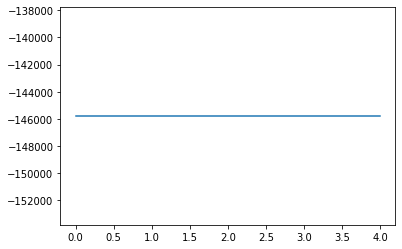

In [10]:
plt.plot(episode_rewards)

In [16]:
desired_goal = env.desired_goal
success = 0
for goal in achieved_goals:
    if (goal == desired_goal).all(axis = 0):
        success += 1
success

0

In [17]:
env.close()

Text(0, 0.5, 'Loss')

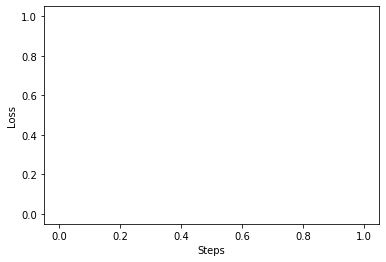

In [8]:
plt.plot(all_losses)
plt.xlabel('Steps')
plt.ylabel('Loss')

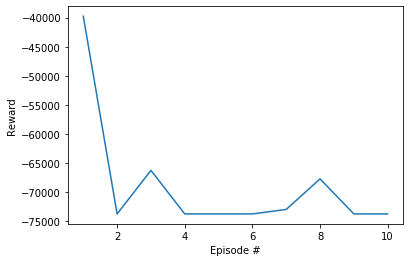

In [9]:
plt.plot(np.arange(1, len(episode_rewards) + 1), episode_rewards)
plt.xlabel('Episode #')
plt.ylabel('Reward')
plt.show()

In [10]:
desired_goal = env.desired_goal

In [18]:
achieved_goals = np.array(achieved_goals)

Text(0.5, 0, 'y-coordinate of achieved goal')

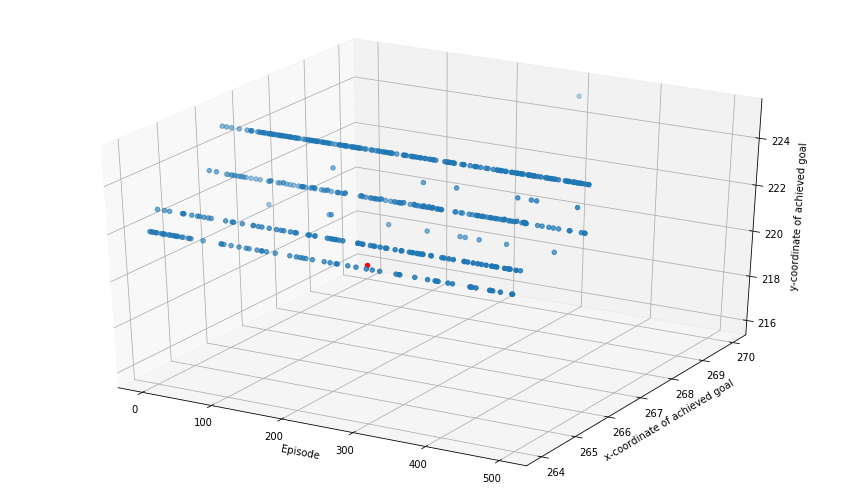

In [19]:
fig = plt.figure(figsize = (15, 9))
ax = plt.axes(projection = '3d')
ax.scatter3D(np.arange(1, num_episodes + 1, 1),
             achieved_goals[:, 0], achieved_goals[:, 1])
ax.scatter3D(1, desired_goal[0], desired_goal[1], color = 'red')
ax.set_xlabel('Episode')
ax.set_ylabel('x-coordinate of achieved goal')
ax.set_zlabel('y-coordinate of achieved goal')

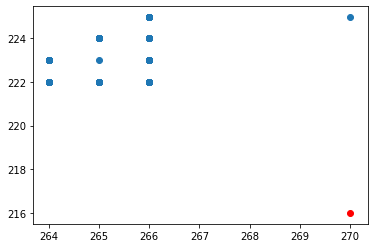

In [20]:
plt.scatter(achieved_goals[:, 0], achieved_goals[:, 1])
plt.scatter(desired_goal[0], desired_goal[1], color = 'red')

In [13]:
goal_errors = []
for goal in achieved_goals:
    goal_errors.append(np.linalg.norm(desired_goal - goal))

Text(0, 0.5, 'Distance from goal')

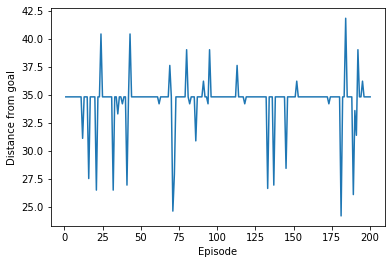

In [14]:
plt.plot(np.arange(1, num_episodes + 1, 1), goal_errors)
plt.xlabel('Episode')
plt.ylabel('Distance from goal')